# Logistic Regression with Bayesian Neural Networks

We'll look at **logistic regression** from a Bayesian Standpoint using [TensorFlow Probability](https://www.tensorflow.org/probability/).

In logistic regression we have:

- any number of independent variables
- a dependent variable that take the value 0 or 1

In order to describe this relationship, we want to fit a curve of the form:

$$
f(x) = \frac{1}{1 + \exp \{ - (w x + b) \}}
$$

The parameters $w$ and $b$ determine the shape of the curve, so we want to find the best values for $w$ and $b$.

We'll attempt to fit a curve for the data relating temperature to O-Ring Failures for the Challenger Disaster.

The plot below shows the data along with a possible logistic curve. This curve seems like a good fit, but we don't have a  sense of how it compares to similar curves. In other words, we have no way of describing the _uncertainty_ of our predictions.

**Bayesian Neural Networks** help us quantify uncertainty.

> This is based on an example in [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb) by Cam Davidson-Pilon, and ported to TensorFlow by Matthew McAteer

In [1]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 46.8MB/s 
     |████████████████████████████████| 3.2MB 31.8MB/s 
     |████████████████████████████████| 61kB 15.7MB/s 
     |████████████████████████████████| 491kB 30.9MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [2]:
# computational
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler

# functional programming
from functools import partial

# plotting
import matplotlib.pyplot as plt

# plot utilities
%matplotlib inline
plt.style.use('ggplot')
def plt_left_title(title): plt.title(title, loc="left", fontsize=18)
def plt_right_title(title): plt.title(title, loc='right', fontsize=13, color='grey')

# use eager execution for better ease-of-use and readability
# tf.enable_eager_execution()

# aliases
tfk = tf.keras
tfd = tfp.distributions

# helper function, mostly for plotting
def logistic(x, w, b):
    exp_term = np.exp(-(x * w + b))
    return 1 / (1 + exp_term)

print(f"            tensorflow version: {tf.__version__}")
print(f"tensorflow probability version: {tfp.__version__}")

            tensorflow version: 1.14.0
tensorflow probability version: 0.7.0


In [3]:
data = np.array([[66.,  0.],
 [70.,  1.],
 [69.,  0.],
 [68.,  0.],
 [67.,  0.],
 [72.,  0.],
 [73.,  0.],
 [70.,  0.],
 [57.,  1.],
 [63.,  1.],
 [70.,  1.],
 [78.,  0.],
 [67.,  0.],
 [53.,  1.],
 [67.,  0.],
 [75.,  0.],
 [70.,  0.],
 [81.,  0.],
 [76.,  0.],
 [79.,  0.],
 [75.,  1.],
 [76.,  0.],
 [58.,  1.]])

# xs: temperature
# ys: o-ring failure (1 == failure occurred)
n_observations = data.shape[0]
xs, ys = data[:, 0, np.newaxis], data[:, 1, np.newaxis]
scaler = StandardScaler()
xs = scaler.fit_transform(xs)
xs_test = np.linspace(xs.min(), xs.max(), 53)[:, np.newaxis]

def plot_training_data(): 
    plt.figure(figsize=(12, 7))
    plt.scatter(xs, ys, c="#619CFF", label="observed", s=200)
    plt.xlabel("Temperature (scaled)")
    plt.ylabel("O-Ring Failure")
    
def plt_left_title(title): plt.title(title, loc="left", fontsize=18)
def plt_right_title(title): plt.title(title, loc='right', fontsize=13, color='grey')
    
print(f"{n_observations} observations")
print(f"{int(ys.sum())} failures")

23 observations
7 failures


Below we train an Artificial Neural Network. It has one hidden layer with a weight and bias ($w$ and $b$), along with a sigmoid activation function. This basically constructs the logistic function, and our loss function helps us find the ideal weights and bias.

A few things to note:
- `xs` is the data for independent variable (temperature) and they are scaled to have mean 0 and standard deviation 1
- `ys` is the data for the dependent variable (O-Ring failure) and they take on values 0 and 1

In [4]:
# train an artificial neural net
nn_model = tfk.Sequential([
    tfk.layers.Dense(1,
                     activation=tf.nn.sigmoid)
])
nn_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
                 loss="binary_crossentropy")
nn_model.fit(xs, ys,
             epochs=800,
             verbose=False);
print(f"estimated w: {nn_model.layers[0].get_weights()[0]}")
print(f"estimated b: {nn_model.layers[0].get_weights()[1]}")

estimated w: [[-1.6023773]]
estimated b: [-1.1075493]


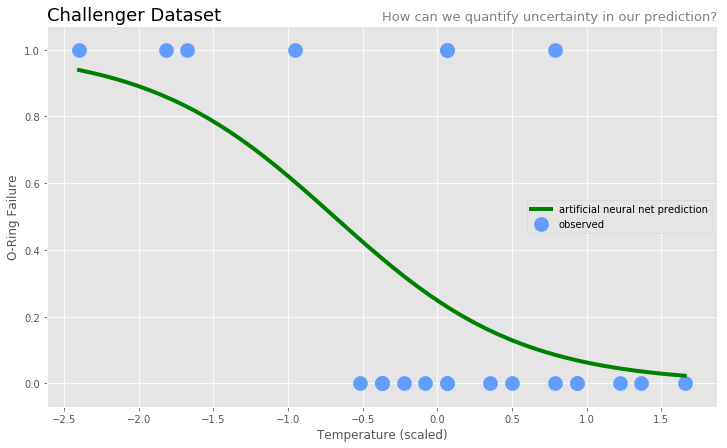

In [5]:
plot_training_data()
plt_left_title("Challenger Dataset")
plt_right_title("How can we quantify uncertainty in our prediction?")

# plot neural network result
plt.plot(xs_test,
         nn_model.predict(xs_test),
         "g", linewidth=4,
         label="artificial neural net prediction")
plt.legend(loc="center right");

So how do we quantify uncertainty? There are two ways:

1. Instead of assuming $w$ and $b$ are numbers, assume they are randomly distributed
2. Have the output of our model be a Bernoulli distribution, to address any randomness in the dependent variable

In order to incorporate these changes, we have to make some adjustments. They are:

1. Use the `tensorflow_probability.layers.DenseFlipout` layer, which allows us to impose distributions on our hidden layer weights
2. Use the [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) as our loss function

The following code makes the proper changes, and was adapted from the [tensorflow examples](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/logistic_regression.py).

In [6]:
# placeholder variables
x = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y = tf.placeholder(shape=[None, 1], dtype=tf.int32)

# flipout layer, which will yield distributions on our weights
# in this case, only one weight and a bias term, each with normal priors
layer = tfp.layers.DenseFlipout(1, 
                                activation=None,
                                kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
                                bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())

# make a prediction
logits = layer(x)
# those predictions are parameters for bernoulli distributions 
labels_dist = tfd.Bernoulli(logits=logits)

# use evidence-lower bound (ELBO) as the loss
neg_log_likelihood = -tf.reduce_mean(labels_dist.log_prob(y))
kl = sum(layer.losses) / n_observations
elbo_loss = neg_log_likelihood + kl

# make predictions, and check accuracy
predictions = tf.cast(logits > 0, dtype=tf.int32)
correct_predictions = tf.equal(predictions, y)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# minimize ELBO
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(elbo_loss)

Now we can train our model. We'll keep track of the following:

- model loss
- model accuracy (this does not affect training)
- candidate $w$'s (weights)
- candidate $b$'s (biases)

Remeber that the weights and biases are not single numbers, but random variables. Furthermore, they will most likely not follow any distribution we've seen before, we we need to take random samples from them. 

Below we train the model, and then plot the loss and accuracy.

In [7]:
n_steps = 1300
n_posterior_samples = 125

history_loss = []
history_acc = []

candidate_ws = []
candidate_bs = []

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    
    # run training loop
    print("Start training...")
    for step in range(n_steps):
        # feed in training data
        feed_dict = {x: xs, y: ys}
        
        # execute the graph 
        _ = sess.run(train_op, feed_dict=feed_dict)
        
        # determine loss and accuracy
        loss_value, acc_value = sess.run([elbo_loss, accuracy],feed_dict=feed_dict)
        
        if ((step + 1) % 100) == 0:
            print(f"{'-'*50} step {step + 1}")
            print(f"Loss {loss_value:.3f}, Accuracy: {acc_value:.3f}")
        
        # record loss and accuracy
        history_loss.append(loss_value)
        history_acc.append(acc_value)
    
    print("Done training!\n")
    print(f"Taking {n_posterior_samples} samples from posterior distributions on weights\n")
    
    w_draw = layer.kernel_posterior.sample(seed=27)
    b_draw = layer.bias_posterior.sample(seed=27)
    
    for mc in range(n_posterior_samples):
        w_, b_ = sess.run([w_draw, b_draw])
        candidate_ws.append(w_)
        candidate_bs.append(b_)
        
    print("Sampling complete. Samples are stored in numpy arrays:")
    print(f"  weight: candidate_ws")
    print(f"    bias: candidate_bs")
        
candidate_ws = np.array(candidate_ws).reshape(-1, 1).astype(np.float32)
candidate_bs = np.array(candidate_bs).astype(np.float32)

Start training...
-------------------------------------------------- step 100
Loss 0.591, Accuracy: 0.783
-------------------------------------------------- step 200
Loss 0.538, Accuracy: 0.870
-------------------------------------------------- step 300
Loss 0.497, Accuracy: 0.826
-------------------------------------------------- step 400
Loss 0.488, Accuracy: 0.870
-------------------------------------------------- step 500
Loss 0.492, Accuracy: 0.870
-------------------------------------------------- step 600
Loss 0.506, Accuracy: 0.826
-------------------------------------------------- step 700
Loss 0.511, Accuracy: 0.826
-------------------------------------------------- step 800
Loss 0.493, Accuracy: 0.870
-------------------------------------------------- step 900
Loss 0.493, Accuracy: 0.870
-------------------------------------------------- step 1000
Loss 0.590, Accuracy: 0.739
-------------------------------------------------- step 1100
Loss 0.856, Accuracy: 0.565
------------

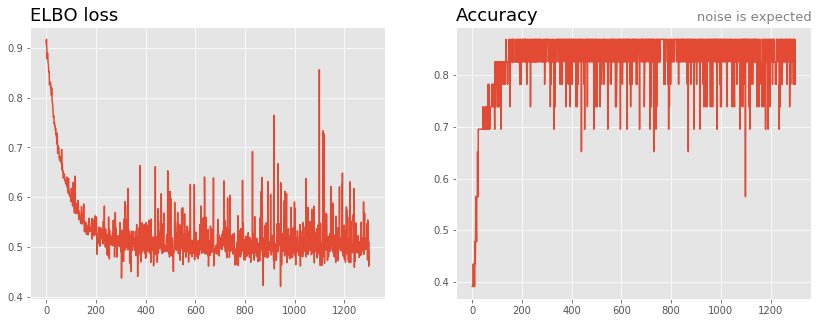

In [8]:
fig = plt.figure(figsize=(14, 5))
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(history_loss)
ax1.set_title("ELBO loss", loc="left", fontsize=18)

ax2.plot(history_acc)
ax2.set_title("Accuracy", loc="left", fontsize=18)
ax2.set_title("noise is expected", loc='right', fontsize=13, color='grey')

plt.show();

Next, let's take a look at how the $w$'s and $b$'s are distributed. 

> Note: These distributions were determined during the model training, and all of the math is handled in `tfp.layers.DenseFlipout`

They don't follow any recognizable distribution, and both take on mostly negative values.

125 posterior samples


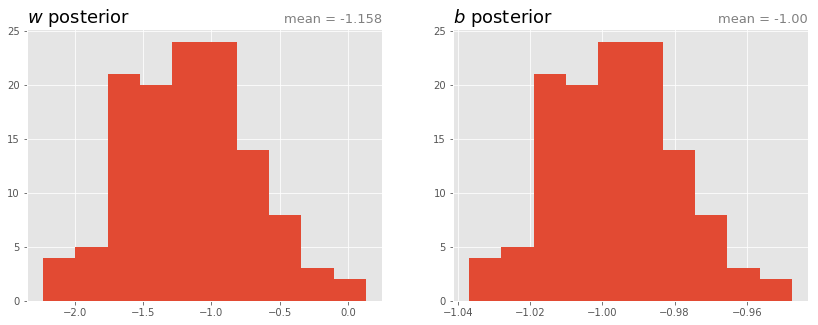

In [9]:
fig = plt.figure(figsize=(14, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.hist(candidate_ws);
ax1.set_title(f"$w$ posterior", loc="left", fontsize=18)
ax1.set_title(f"mean = {candidate_ws.mean():.3f}", loc='right', fontsize=13, color='grey')

ax2.hist(candidate_bs)
ax2.set_title(f"$b$ posterior", loc="left", fontsize=18)
ax2.set_title(f"mean = {candidate_bs.mean():.2f}", loc='right', fontsize=13, color='grey')

print(f"{n_posterior_samples} posterior samples")

Lastly, we'll plot 125 possible logistic curves for this data. 

This plot gives us a better sense of the uncertainty in our model. We can make a few observations:
- a positive-sloping curve is very unlikely, given the data
- the mean of the candidate curves (dotted line) is less aggressive than our original prediction
- the original prediction is not an unlikely candidate, given the data

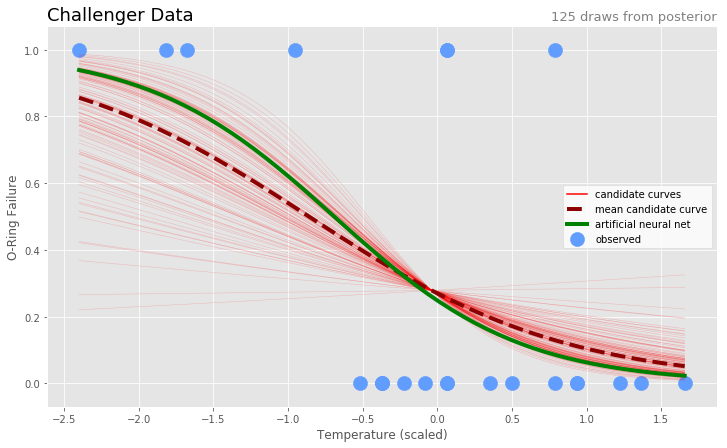

In [10]:
plot_training_data()
plt_left_title("Challenger Data")
plt_right_title(f"{n_posterior_samples} draws from posterior")

# plot candidate curves
plt.plot(xs_test, 
         logistic(xs_test, candidate_ws.T, candidate_bs.T), 
         'r', alpha=0.2, linewidth=0.5);
# this is a placeholder for the labels -- no data is plotted
plt.plot([], [], 'r',
         label=f"candidate curves")
# plot candidate curve based on mean weights
plt.plot(xs_test, 
         logistic(xs_test, candidate_ws.mean(), candidate_bs.mean()), 
         '--', c='darkred', linewidth=4, 
         label="mean candidate curve")
# plot neural network result
plt.plot(xs_test,
         nn_model.predict(xs_test),
         "g", linewidth=4,
         label="artificial neural net")
plt.legend(loc="center right", facecolor="white");

Was our our original prediction better? In terms of minimizing loss, yes. In terms of giving us a better understanding of the underlying model, not so much.

The Bayesian approach gives us much more information with just a few changes, and lets us address the uncertainty in our data, our models, and our assumptions.